## 1. Load and Preview Data

### Import necessary libraries

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
from sentence_transformers import SentenceTransformer

### Load raw CSV dataset and rename columns

In [ ]:
df = pd.read_csv("../data/raw/1_10_seasons_tbbt.csv", delimiter=',', encoding='utf8') 
df.rename(columns = {'person_scene':'Person', 'dialogue':'Said'}, inplace = True)
df['Season'] = df['episode_name'].str.extract(r'Series (\d{2})').astype(int)
df = df[['Person', 'Said', 'Season']]

# Remove "Scene" and "(off)"
df = df[~df['Person'].isin(['Scene', '(off)'])]

# Replace "Cooper" with "Mary" (Sheldon's mother)
df['Person'] = df['Person'].replace({'Cooper': 'Mary'})

print(df.head())

         Person                                               Said  Season
1       Sheldon   So if a photon is directed through a plane wi...       1
2       Leonard                         Agreed, what’s your point?       1
3       Sheldon   There’s no point, I just think it’s a good id...       1
4       Leonard                                         Excuse me?       1
5  Receptionist                                          Hang on.        1


## 2. Character Frequency Analysis

### Analyze distribution

Top 20 characters by number of dialogues:

1. Sheldon: 11484 dialogues (22.37%)
2. Leonard: 9638 dialogues (18.77%)
3. Penny: 7477 dialogues (14.56%)
4. Howard: 5737 dialogues (11.17%)
5. Raj: 4576 dialogues (8.91%)
6. Amy: 3419 dialogues (6.66%)
7. Bernadette: 2636 dialogues (5.13%)
8. Stuart: 726 dialogues (1.41%)
9. Mary: 274 dialogues (0.53%)
10. Priya: 213 dialogues (0.41%)
11. Emily: 162 dialogues (0.32%)
12. Beverley: 159 dialogues (0.31%)
13. Zack: 133 dialogues (0.26%)
14. Arthur: 130 dialogues (0.25%)
15. Wil: 125 dialogues (0.24%)
16. Man: 108 dialogues (0.21%)
17. Leslie: 107 dialogues (0.21%)
18. Kripke: 103 dialogues (0.20%)
19. Koothrappali: 100 dialogues (0.19%)
20. Bert: 95 dialogues (0.19%)


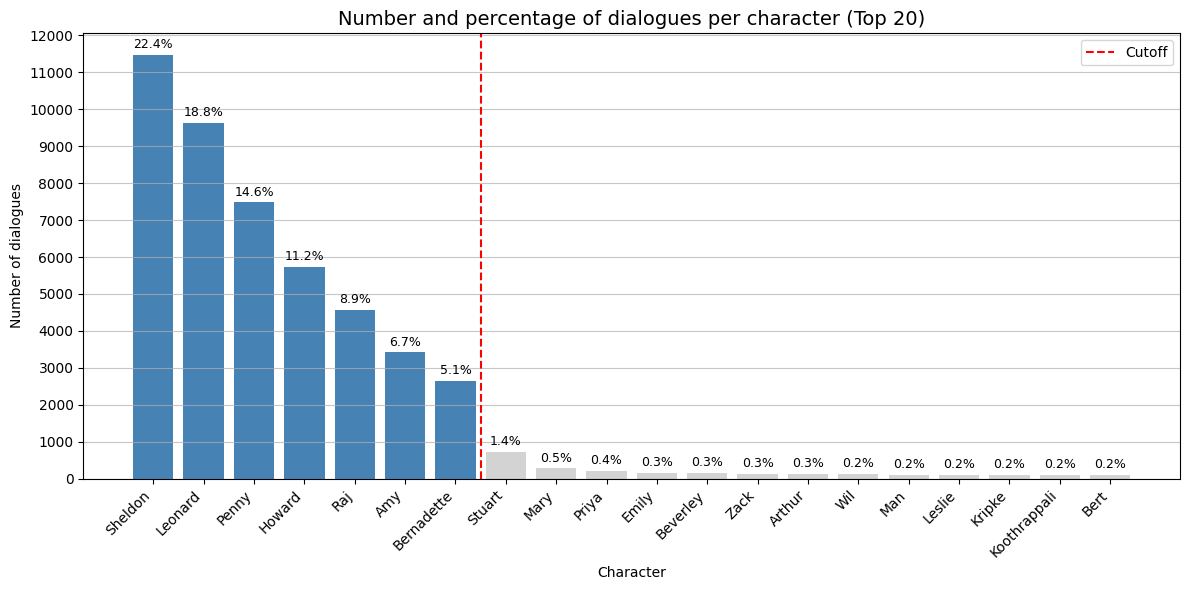

In [ ]:
# Compute frequency of each character's lines
top_20 = df['Person'].value_counts().head(20)
total_dialogues = len(df)

# Print ranking with percentages
print("Top 20 characters by number of dialogues:\n")
for i, (person, count) in enumerate(top_20.items(), start=1):
    perc = (count / total_dialogues) * 100
    print(f"{i}. {person}: {count} dialogues ({perc:.2f}%)")

# Plot
plt.figure(figsize=(12, 6))
colors = ['steelblue' if i < 7 else 'lightgray' for i in range(len(top_20))]
bars = plt.bar(top_20.index, top_20.values, color=colors)

# Add percentages above bars
for bar, count in zip(bars, top_20.values):
    perc = (count / total_dialogues) * 100
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + total_dialogues * 0.002,
             f"{perc:.1f}%", ha='center', va='bottom', fontsize=9)

# Vertical line after Bernadette
plt.axvline(x=6.5, color='red', linestyle='--', label='Cutoff')

# Labels and style
plt.title('Number and percentage of dialogues per character (Top 20)', fontsize=14)
plt.ylabel('Number of dialogues')
plt.xlabel('Character')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.legend()
plt.grid(axis='y', linestyle='-', alpha=0.7)
plt.yticks(range(0, max(top_20.values) + 1000, 1000))

plt.savefig('../images/dialogues_top20_percentage_cutoff.png', dpi=300)

plt.show()

### Keep only main characters

In [14]:
persons = ['Sheldon', 'Leonard', 'Raj', 'Penny','Howard','Amy','Bernadette']
data = df[df.Person.isin(persons)]
print(len(data), "dialogues for main characters")

44967 dialogues for main characters


### Drop empty line

In [15]:
data = data.dropna()
data = data.reset_index(drop=True)
print(len(data), "dialogues for main characters after dropping empty lines")

44966 dialogues for main characters after dropping empty lines


### Pie chart of dialogues ditribution

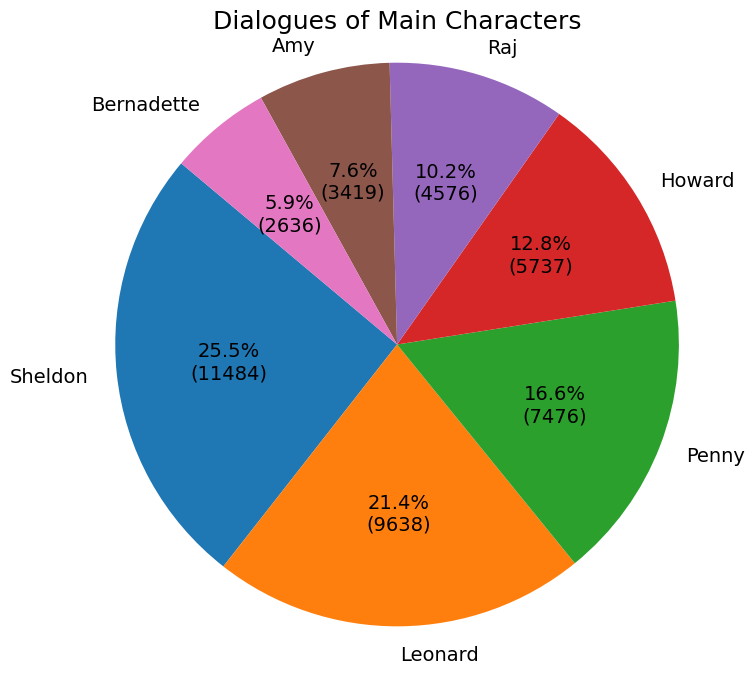

In [ ]:
# Compute frequency of each character's lines
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct * total / 100.0))
        return f'{pct:.1f}%\n({val})'
    return my_format

plt.figure(figsize=(8, 8))
counts = data['Person'].value_counts()
plt.pie(
    counts,
    labels=counts.index,
    autopct=autopct_format(counts),
    startangle=140,
    textprops={'fontsize': 14}
)
plt.title('Dialogues of Main Characters', fontsize=18)
plt.axis('equal')
plt.savefig('../images/dialogues_main_characters_pie.png', dpi=300)
plt.show()

### Line chart grouped by seasons

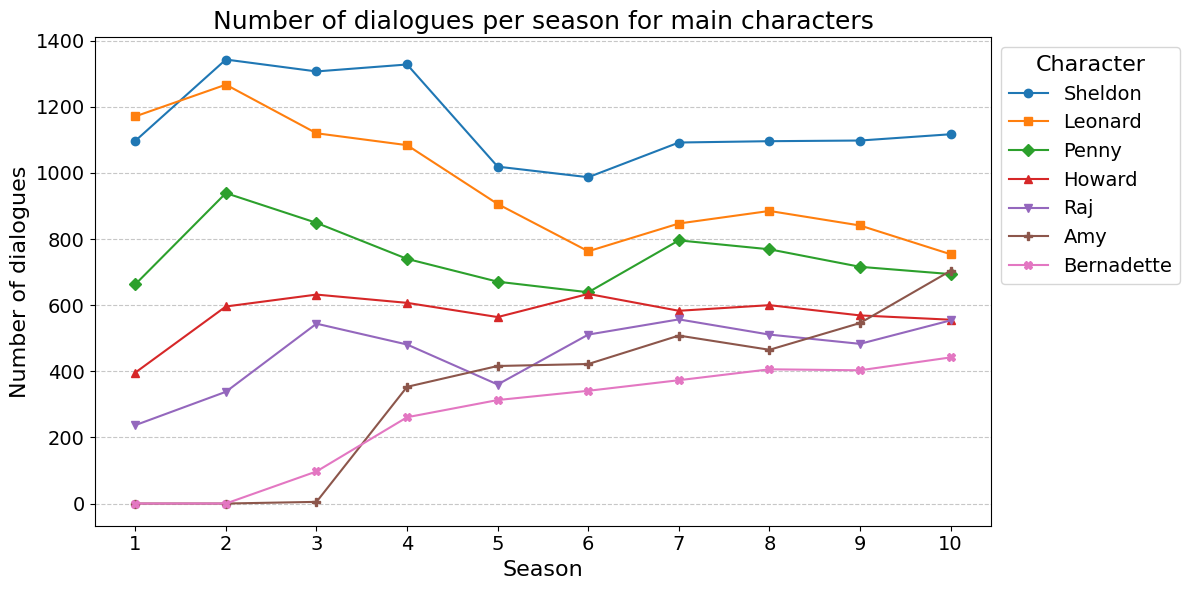

In [8]:
# Group by Season and Person, count dialogues
grouped = data.groupby(['Season', 'Person']).size().unstack(fill_value=0)

persons = data['Person'].value_counts().index.tolist()

# Define a marker for each person
person_markers = {
    'Sheldon': 'o',
    'Leonard': 's',
    'Penny': 'D',
    'Howard': '^',
    'Raj': 'v',
    'Amy': 'P',
    'Bernadette': 'X'
}

plt.figure(figsize=(12, 6))
for person in persons:
    plt.plot(
        grouped.index,
        grouped[person],
        marker=person_markers.get(person, 'o'),
        label=person
    )

plt.xlabel('Season', fontsize=16)
plt.ylabel('Number of dialogues', fontsize=16)
plt.title('Number of dialogues per season for main characters', fontsize=18)
plt.xticks(grouped.index, fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title='Character', labels=persons, bbox_to_anchor=(1, 1), loc='upper left', fontsize=14, title_fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

## 4. Compute SBERT Embeddings

### Encode each sentence into SBERT embeddings

In [ ]:
# Load the model
model = SentenceTransformer('all-minilm-L6-v2')

# Compute embeddings with progress feedback
new_column_values = []
total = len(data)

for i in range(total):
    text = data.iloc[i]['Said']
    embedding = model.encode(text)
    new_column_values.append(embedding)
    
    if (i + 1) % 100 == 0 or (i + 1) == total:
        print(f"Processed {i+1}/{total} texts")

# Add embeddings to the dataframe
data['Embedding'] = new_column_values

# Save the dataframe to a pickle file
data.to_pickle('../data/processed/sbert_mini_embeddings.pkl')